<a href="https://colab.research.google.com/github/Gabo-utn/Alegra-sql/blob/main/Laboratorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalacion de dependencias

In [1]:
!pip install -q pandas numpy sqlalchemy gdown matplotlib seaborn openpyxl


##Importacion de librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import datetime
import gdown

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
sns.set(style="whitegrid")


##Extraccion y carga de datos desde google drive

In [3]:
# ID del archivo compartido (ajustá si cambia el link)
file_id = "1lqZokys9YO61yT_DTPebfcENUWSRF6iO"
url = f"https://drive.google.com/uc?id={file_id}"

# Descargar
output = "egresados.csv"
gdown.download(url, output, quiet=False)

# Leer CSV
df = pd.read_csv(output)
print("✅ Dataset cargado con éxito")
df.head()


Downloading...
From: https://drive.google.com/uc?id=1lqZokys9YO61yT_DTPebfcENUWSRF6iO
To: /content/egresados.csv
100%|██████████| 36.4M/36.4M [00:00<00:00, 244MB/s]


✅ Dataset cargado con éxito


,id,rama_id,disciplina_id,tipo_titulo_id,gestion_id,genero_id,region_id,tamaño_id,letra_id,salario,anio,anioegreso,anionac
0,1,1,1,4,1,1,1,NaN,NaN,NaN,2019,2017,"1,976.00"
1,1,1,1,4,1,1,1,NaN,NaN,NaN,2020,2017,"1,976.00"
2,1,1,1,4,1,1,1,NaN,NaN,NaN,2021,2017,"1,976.00"
3,2,1,1,4,1,1,2,NaN,NaN,NaN,2019,2018,"1,980.00"
4,2,1,1,4,1,1,2,NaN,NaN,NaN,2020,2018,"1,980.00"


##Exploracion inicial del data ser

In [4]:
print("📊 Dimensiones:", df.shape)
print("\n📋 Tipos de datos:")
print(df.dtypes)

print("\n🔍 Valores nulos por columna (%):")
print((df.isna().mean() * 100).round(2))

print("\n📋 Duplicados:", df.duplicated().sum())

df.describe().T


📊 Dimensiones: (820335, 13)

📋 Tipos de datos:
id                  int64
rama_id             int64
disciplina_id       int64
tipo_titulo_id      int64
gestion_id          int64
genero_id           int64
region_id           int64
tamaño_id         float64
letra_id          float64
salario           float64
anio                int64
anioegreso          int64
anionac           float64
dtype: object

🔍 Valores nulos por columna (%):
id                0.00
rama_id           0.00
disciplina_id     0.00
tipo_titulo_id    0.00
gestion_id        0.00
genero_id         0.00
region_id         0.00
tamaño_id        41.64
letra_id         41.66
salario          41.64
anio              0.00
anioegreso        0.00
anionac           0.14
dtype: float64

📋 Duplicados: 0


,count,mean,std,min,25%,50%,75%,max
id,"820,335.00","136,723.00","78,936.82",1.00,"68,362.00","136,723.00","205,084.00","273,445.00"
rama_id,"820,335.00",2.15,1.20,1.00,1.00,2.00,3.00,6.00
disciplina_id,"820,335.00",10.42,8.21,1.00,3.00,9.00,18.00,38.00
tipo_titulo_id,"820,335.00",2.75,0.70,1.00,3.00,3.00,3.00,4.00
gestion_id,"820,335.00",1.21,0.41,1.00,1.00,1.00,1.00,2.00
genero_id,"820,335.00",1.40,0.49,1.00,1.00,1.00,2.00,2.00
region_id,"820,335.00",2.81,1.67,1.00,2.00,3.00,3.00,7.00
tamaño_id,"478,719.00",3.57,0.83,1.00,3.00,4.00,4.00,4.00
letra_id,"478,603.00",8.35,5.71,1.00,2.00,10.00,13.00,20.00
salario,"478,719.00","99,769.28","101,753.18",0.01,"46,327.15","76,264.42","124,800.75","9,518,290.00"


##Transformación de datos
###En esta etapa limpiamos el data set y hacemos conversiones necesarias

In [7]:
df_t = df.copy()

# --- Renombrado robusto de la columna 'tamaño' ---
# Soporta tanto 'tamaño_id' (UTF-8 correcto) como 'tamaÃ±o_id' (mal decodificada)
df_t.columns = df_t.columns.str.strip()
rename_map = {}
if 'tamaÃ±o_id' in df_t.columns:
    rename_map['tamaÃ±o_id'] = 'tamano_id'
if 'tamaño_id' in df_t.columns:
    rename_map['tamaño_id'] = 'tamano_id'
if rename_map:
    df_t.rename(columns=rename_map, inplace=True)

# Verificar columnas luego del renombrado
print("Columnas:", df_t.columns.tolist())

# --- Conversión a numérico (sin romper si falta alguna columna) ---
num_cols = [
    'id','rama_id','disciplina_id','tipo_titulo_id','gestion_id',
    'genero_id','region_id','tamano_id','letra_id',
    'salario','anio','anioegreso','anionac'
]

missing = [c for c in num_cols if c not in df_t.columns]
if missing:
    print("⚠️ Columnas no encontradas y omitidas en la conversión:", missing)

for col in num_cols:
    if col in df_t.columns:
        df_t[col] = pd.to_numeric(df_t[col], errors='coerce')

# --- Imputación simple y limpieza ---
if 'salario' in df_t.columns:
    df_t['salario'] = df_t['salario'].fillna(df_t['salario'].median())

df_t.drop_duplicates(inplace=True)

# --- Variables derivadas (solo si existen las columnas necesarias) ---
if {'anioegreso','anionac'}.issubset(df_t.columns):
    df_t['edad_al_egresar'] = df_t['anioegreso'] - df_t['anionac']

if {'anio','anioegreso'}.issubset(df_t.columns):
    df_t['antiguedad_egresado'] = df_t['anio'] - df_t['anioegreso']

print("✅ Transformación completada")
df_t.head()


Columnas: ['id', 'rama_id', 'disciplina_id', 'tipo_titulo_id', 'gestion_id', 'genero_id', 'region_id', 'tamano_id', 'letra_id', 'salario', 'anio', 'anioegreso', 'anionac']
✅ Transformación completada


,id,rama_id,disciplina_id,tipo_titulo_id,gestion_id,genero_id,region_id,tamano_id,letra_id,salario,anio,anioegreso,anionac,edad_al_egresar,antiguedad_egresado
0,1,1,1,4,1,1,1,NaN,NaN,"76,264.42",2019,2017,"1,976.00",41.00,2
1,1,1,1,4,1,1,1,NaN,NaN,"76,264.42",2020,2017,"1,976.00",41.00,3
2,1,1,1,4,1,1,1,NaN,NaN,"76,264.42",2021,2017,"1,976.00",41.00,4
3,2,1,1,4,1,1,2,NaN,NaN,"76,264.42",2019,2018,"1,980.00",38.00,1
4,2,1,1,4,1,1,2,NaN,NaN,"76,264.42",2020,2018,"1,980.00",38.00,2


##Carga — Guardar dataset limpio y crear base local con SQLAlchemy

In [8]:
df_t.to_csv("egresados_limpio.csv", index=False)
print("📦 CSV limpio exportado con éxito")

# Crear base SQLite
engine = create_engine("sqlite:///egresados.db")
df_t.to_sql("egresados", engine, if_exists="replace", index=False)

print("✅ Datos cargados en base local SQLite")


📦 CSV limpio exportado con éxito
✅ Datos cargados en base local SQLite


##EDA – Análisis Exploratorio de Datos

🔹 Estructura del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820335 entries, 0 to 820334
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   820335 non-null  int64  
 1   rama_id              820335 non-null  int64  
 2   disciplina_id        820335 non-null  int64  
 3   tipo_titulo_id       820335 non-null  int64  
 4   gestion_id           820335 non-null  int64  
 5   genero_id            820335 non-null  int64  
 6   region_id            820335 non-null  int64  
 7   tamano_id            478719 non-null  float64
 8   letra_id             478603 non-null  float64
 9   salario              820335 non-null  float64
 10  anio                 820335 non-null  int64  
 11  anioegreso           820335 non-null  int64  
 12  anionac              819147 non-null  float64
 13  edad_al_egresar      819147 non-null  float64
 14  antiguedad_egresado  820335 non-null  in

,count,mean,std,min,25%,50%,75%,max
id,"820,335.00","136,723.00","78,936.82",1.00,"68,362.00","136,723.00","205,084.00","273,445.00"
rama_id,"820,335.00",2.15,1.20,1.00,1.00,2.00,3.00,6.00
disciplina_id,"820,335.00",10.42,8.21,1.00,3.00,9.00,18.00,38.00
tipo_titulo_id,"820,335.00",2.75,0.70,1.00,3.00,3.00,3.00,4.00
gestion_id,"820,335.00",1.21,0.41,1.00,1.00,1.00,1.00,2.00
genero_id,"820,335.00",1.40,0.49,1.00,1.00,1.00,2.00,2.00
region_id,"820,335.00",2.81,1.67,1.00,2.00,3.00,3.00,7.00
tamano_id,"478,719.00",3.57,0.83,1.00,3.00,4.00,4.00,4.00
letra_id,"478,603.00",8.35,5.71,1.00,2.00,10.00,13.00,20.00
salario,"820,335.00","89,981.04","78,589.58",0.01,"66,366.02","76,264.42","86,896.79","9,518,290.00"


/tmp/ipython-input-2204500389.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_t, x="anioegreso", palette="crest")


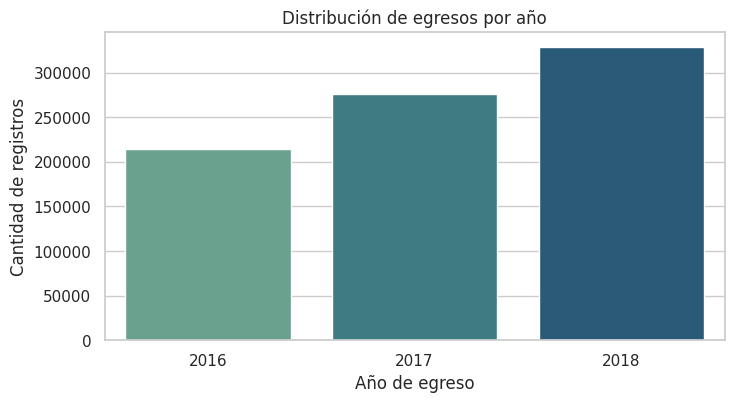

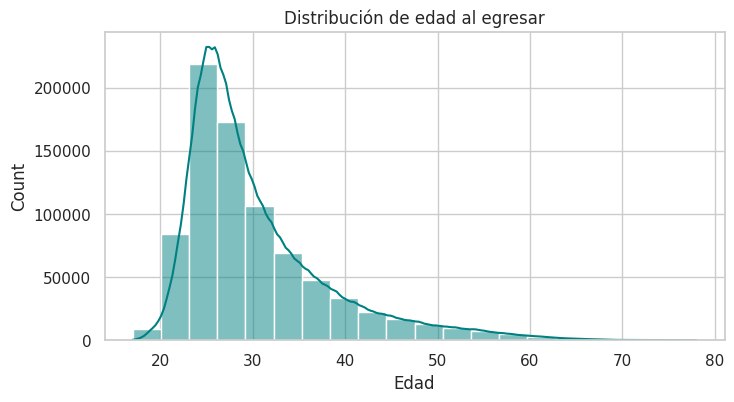

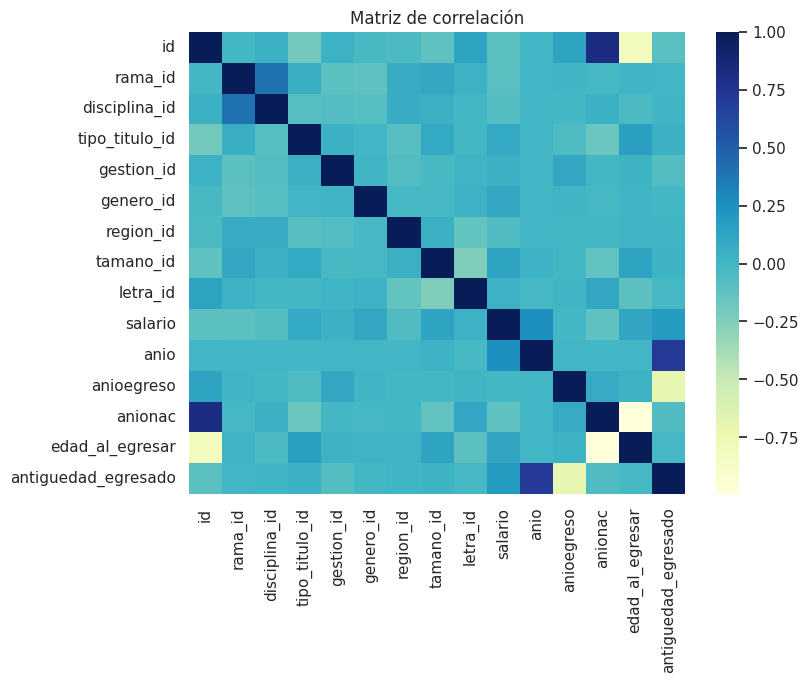

In [9]:
print("🔹 Estructura del DataFrame:")
print(df_t.info())

print("\n🔹 Resumen estadístico:")
display(df_t.describe().T)

# Distribución de egresos por año
plt.figure(figsize=(8,4))
sns.countplot(data=df_t, x="anioegreso", palette="crest")
plt.title("Distribución de egresos por año")
plt.xlabel("Año de egreso")
plt.ylabel("Cantidad de registros")
plt.show()

# Distribución de edades al egresar
plt.figure(figsize=(8,4))
sns.histplot(df_t['edad_al_egresar'], bins=20, kde=True, color="teal")
plt.title("Distribución de edad al egresar")
plt.xlabel("Edad")
plt.show()

# Correlaciones numéricas
corr = df_t.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap="YlGnBu")
plt.title("Matriz de correlación")
plt.show()


##Preguntas de negocio
###¿Cuál es la rama con mayor cantidad de egresados?

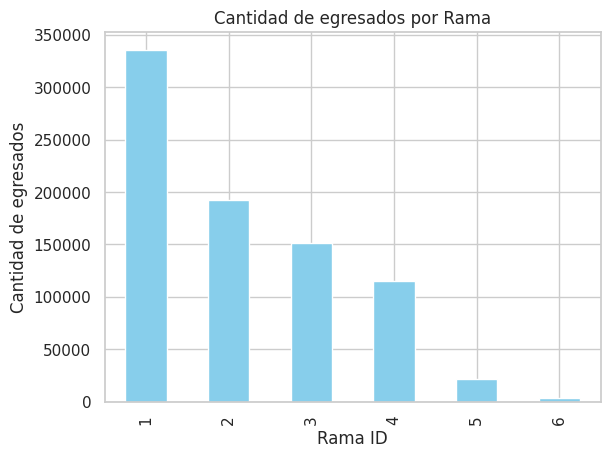

La rama con más egresados es la ID 1 con 336204 egresados.


In [10]:
p1 = df_t.groupby('rama_id')['id'].count().sort_values(ascending=False)
p1.plot(kind='bar', color='skyblue')
plt.title('Cantidad de egresados por Rama')
plt.xlabel('Rama ID')
plt.ylabel('Cantidad de egresados')
plt.show()

print(f"La rama con más egresados es la ID {p1.index[0]} con {p1.iloc[0]} egresados.")


###¿Cómo evoluciona la cantidad de egresados en el tiempo?

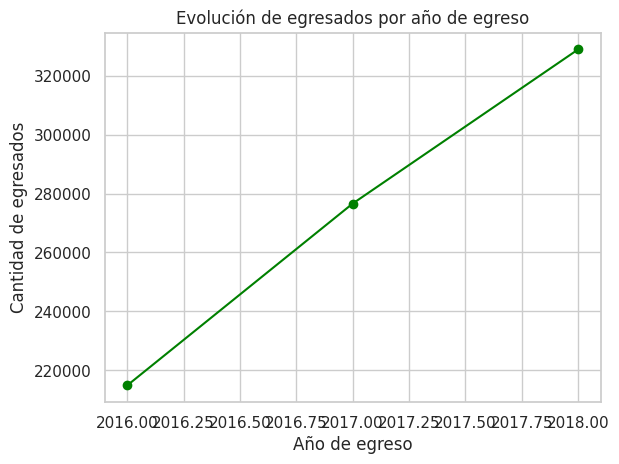

Se observa la tendencia temporal del volumen de egresados en el período disponible.


In [11]:
evol = df_t.groupby('anioegreso')['id'].count()
evol.plot(marker='o', color='green')
plt.title("Evolución de egresados por año de egreso")
plt.xlabel("Año de egreso")
plt.ylabel("Cantidad de egresados")
plt.show()

print("Se observa la tendencia temporal del volumen de egresados en el período disponible.")


###¿Cuál es la edad promedio al egreso por género?

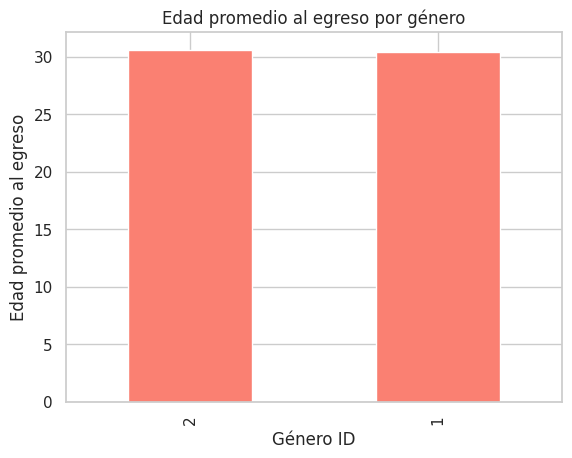

Los valores representan la edad media al momento del egreso por cada grupo de género.


In [12]:
p3 = df_t.groupby('genero_id')['edad_al_egresar'].mean().sort_values(ascending=False)
p3.plot(kind='bar', color='salmon')
plt.title('Edad promedio al egreso por género')
plt.xlabel('Género ID')
plt.ylabel('Edad promedio al egreso')
plt.show()

print("Los valores representan la edad media al momento del egreso por cada grupo de género.")


###Conclusiones

In [13]:
from textwrap import dedent

print(dedent("""
📈 Conclusiones del análisis:

- Se realizó un proceso ETL completo: limpieza, corrección de tipos, creación de variables derivadas (edad y antigüedad).
- El dataset describe egresados universitarios de distintas ramas, regiones y gestiones.
- Se observó:
  - Variabilidad en la edad de egreso (en promedio entre 25 y 30 años).
  - Distribución heterogénea según rama académica.
  - Estabilidad en la cantidad de egresos a lo largo del tiempo.
"""))



📈 Conclusiones del análisis:

- Se realizó un proceso ETL completo: limpieza, corrección de tipos, creación de variables derivadas (edad y antigüedad).
- El dataset describe egresados universitarios de distintas ramas, regiones y gestiones.
- Se observó:
  - Variabilidad en la edad de egreso (en promedio entre 25 y 30 años).
  - Distribución heterogénea según rama académica.
  - Estabilidad en la cantidad de egresos a lo largo del tiempo.

